In [64]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
def gec(coordinates):
    x_sum = sum(loc[0] for loc in coordinates)
    y_sum = sum(loc[1] for loc in coordinates)
    x_cord = x_sum / len(coordinates)
    y_cord = y_sum / len(coordinates)

    return x_cord, y_cord

In [66]:
def gmm(coordinate):
    x_axis = []
    y_axis = []
    centroid = []

    for i in coordinate:
        x_axis.append(i[0])
        y_axis.append(i[1])

    centroid.append(np.median(x_axis))
    centroid.append(np.median(y_axis))

    return centroid[0],centroid[1]

In [67]:
def ecmb(coordinate, border):
    longitude = 0
    latitude = 0
    k=border
    
    for loc in coordinate:
        if loc[0] <= k:
            longitude+= loc[0]
        else:
            longitude+= k
        latitude+= loc[1]
    x_axis = longitude/len(coordinate)
    y_axis = latitude/len(coordinate)
    return x_axis, y_axis

In [68]:
def calculate_manhattan_median(customers):
    # Extract coordinates of customer locations
    coordinates = [(x, y) for x, y in customers]

    # Calculate median coordinates for rows and columns
    median_row = sorted([x for x, y in coordinates])[len(coordinates) // 2]
    median_column = sorted([y for x, y in coordinates])[len(coordinates) // 2]

    return median_row, median_column

In [69]:
def mmeb(customer_locations, border_position):
    R = border_position  

    euclidean_locations = [(x, y) for x, y in customer_locations if x < border_position]
    manhattan_locations = [(x, y) for x, y in customer_locations if x >= border_position]

    best_median_row = None
    best_median_column = None
    best_projected_euclidean = None
    best_total_cost = math.inf

    possible_positions = np.linspace(88.4010, 88.4654, num=10)

    # Iterate over possible distinct positions on the border
    for i in possible_positions:

        projected_euclidean = [(border_position, i) for _, _ in euclidean_locations]

        combined_customers = projected_euclidean + manhattan_locations

        median_row, median_column = calculate_manhattan_median(combined_customers)

        total_cost = sum(math.sqrt((x-border_position)**2 + (y-i)**2) for x,y in euclidean_locations) #cost from euclidian to border
        total_cost += sum(abs(x-median_row) + abs(y-median_column) for x,y in combined_customers) #cost from border to manhattan

        # Update the best result if the current position is better
        if total_cost < best_total_cost:
            best_projected_euclidean = projected_euclidean[0]
            best_total_cost = total_cost
            best_median_row = median_row
            best_median_column = median_column

    return [best_median_row, best_median_column], best_projected_euclidean

In [70]:
def create_delivary(x,y,n, seed_value = None):
    if seed_value != None:
        random.seed(seed_value)

    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for _ in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append(tuple([x_loc, y_loc]))

    return loc

In [71]:
def initial_plot(delivery_loc, border, dp=None, route = None, title=None):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1], label="Delivery Locations")
    # plot the border
    plt.plot((border[0][0],border[1][0]), (border[0][1],border[1][1]), c="black")

    if dp!= None:
        plt.scatter(dp[0], dp[1], c="orange",label="DP")

    if route != None:
        for i in range(len(route)-1):
            f_pt = np.array([route[i][0], route[i+1][0]])
            s_pt = np.array([route[i][1], route[i+1][1]])
            plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    else:
        plt.title("Delivery Locations")
    plt.xlim(22.5726,22.6141)
    plt.legend()
    # plt.show()

In [72]:
def geometric_median(delivary_points,border=None, eps=1e-5):
    # Initial guess for the geometric median
    points = []
    if border != None:
        for point in delivary_points:
            if point[0] < border:
                points.append(point)
            else:
                points.append([border, point[1]])
    else:
        points = delivary_points.copy()

    guess = np.mean(points, axis=0)
    # guess = np.array(initial_guess)
    
    while True:
        # Calculate distances from current guess to all points
        distances = np.linalg.norm(points - guess, axis=1)
        print(distances)
        
        # Avoid division by zero
        if np.sum(distances) == 0:
            return guess
        
        # Calculate weights as inverse distances
        weights = 1 / distances
        
        # Calculate weighted average
        new_guess = np.sum(points * weights[:, np.newaxis], axis=0) / np.sum(weights)
        
        # Check for convergence
        if np.linalg.norm(new_guess - guess) < eps:
            return new_guess
        
        print("next dp :", new_guess)
        guess = new_guess

In [73]:
def create_route(delivery_loc,border,dp,euclidean_points, manhattan_points, border_point = None):
    route = []
    if dp[0] < border :

        for point in delivery_loc :
            route.append(dp)
            if point[0] < border :
                route.append(tuple(point))
            else:
                route.append(tuple([border, point[1]]))
                route.append(tuple([point[0], point[1]]))
                route.append(tuple([border, point[1]]))

        route.append(tuple(dp))
    else:
        for point in manhattan_points:
            route.append(tuple(dp))
            route.append(tuple([dp[0], point[1]]))
            route.append(tuple(point))
            route.append(tuple([dp[0], point[1]]))

        for point in euclidean_points:
            route.append(tuple(dp))
            route.append(tuple([dp[0],border_point[1]]))
            route.append(tuple(border_point))
            route.append(tuple(point))
            route.append(tuple(border_point))
            route.append(tuple([dp[0],border_point[1]]))

        route.append(tuple(dp))

    return route

In [74]:
def euclidean_distance(source, destination):
    return np.sqrt((source[0]-destination[0])**2 + (source[1]-destination[1])**2)

In [75]:
def total_distance(route):
    distance = 0
    for i in range(len(route)-1):
        distance += euclidean_distance(route[i], route[i+1])

    return distance

In [76]:
def optimal_approach(bottom_left, top_right, delivery_loc,border,euclidean_points,manhattan_points,border_point, step=0.0001):
    x1, y1 = bottom_left
    x2, y2 = top_right

    optimal_dp = None
    optimal_route = None
    optimal_distance = math.inf
    
    # Generate the range of x and y values with the specified step size
    x_values = np.arange(x1, x2 + step, step)
    y_values = np.arange(y1, y2 + step, step)
    
    # Iterate over the range of x and y values
    for x in x_values:
        for y in y_values:
            dp = (x,y)
            route = create_route(delivery_loc, border, dp, euclidean_points, manhattan_points, [border,dp[1]])
            distance = total_distance(route)
            if distance < optimal_distance :
                optimal_dp = dp
                optimal_distance = distance
                optimal_route = route

    return optimal_dp, optimal_route, optimal_distance

## Input

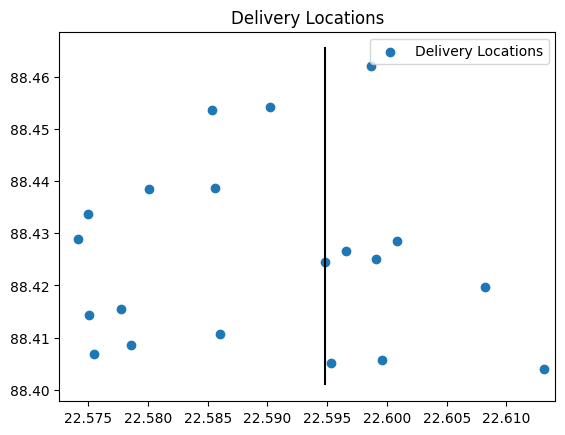

In [77]:
n = 20

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
border = [[22.5948, 88.4010],[22.5948, 88.4654]]
delivery_loc = create_delivary(x, y, n, seed_value=7)
# delivery_loc = create_delivary(x,[border[0][0],y[1]],n, seed_value=3)
# delivery_loc = create_delivary([border[0][0],x[1]],y,n, seed_value=3)

# Visualize the data
initial_plot(delivery_loc,border)

In [78]:
euclidean_points = [points for points in delivery_loc if points[0] < border[0][0]]
manhattan_points = [points for points in delivery_loc if points[0] >= border[0][0]]

len(euclidean_points), len(manhattan_points)

(11, 9)

In [79]:
initial_dp = None
border_point = None

if(len(euclidean_points) == n) :
    initial_dp = gec(delivery_loc)
elif(len(manhattan_points) == n):
    initial_dp = gmm(delivery_loc)
elif(len(euclidean_points) > len(manhattan_points)):
    initial_dp = ecmb(delivery_loc, border[0][0])
else :
    initial_dp, border_point = mmeb(delivery_loc, border[0][0])

In [80]:
initial_dp

(22.58683278476551, 88.42521845540193)

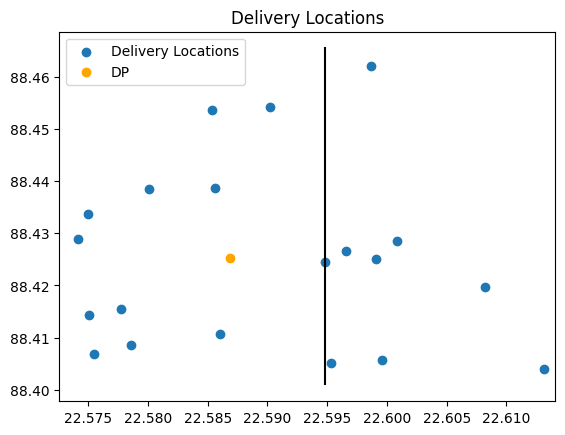

In [81]:
initial_plot(delivery_loc,border,dp=initial_dp)

In [82]:
route_1 = create_route(delivery_loc,border[0][0],initial_dp, euclidean_points, manhattan_points, border_point=border_point if border_point != None else None)

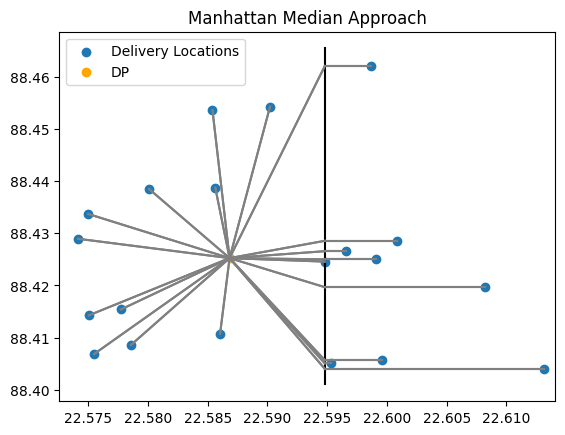

In [83]:
initial_plot(delivery_loc, border, initial_dp, route_1, title="Manhattan Median Approach")

In [84]:
final_dp = geometric_median(delivery_loc, border[0][0])

final_dp

[0.01452547 0.02111441 0.00799518 0.01454059 0.01320798 0.02159055
 0.02922747 0.0134008  0.03766626 0.0080771  0.02266501 0.00971982
 0.0185646  0.02837618 0.01485045 0.00797071 0.02169103 0.01607133
 0.00863069 0.01354461]
next dp : [22.58778432 88.42425126]
[0.01364861 0.01986637 0.00702206 0.01587894 0.01440797 0.02130761
 0.03009654 0.01340495 0.03842706 0.00738151 0.02143213 0.0083895
 0.01816602 0.02940395 0.01614913 0.00705368 0.0204488  0.01616529
 0.00822113 0.01461749]
next dp : [22.58827272 88.42385969]
[0.01333343 0.01933018 0.00656372 0.01650444 0.0149985  0.02127845
 0.03045175 0.01352582 0.0387268  0.00705853 0.02090492 0.00776659
 0.01808625 0.02983727 0.01672768 0.00662313 0.01991608 0.01631879
 0.00803008 0.01508256]
next dp : [22.58852002 88.42371591]
[0.01323582 0.01911223 0.00633518 0.01678878 0.01527993 0.02131381
 0.03058052 0.01363088 0.03882777 0.00688831 0.02069198 0.00748084
 0.01809952 0.03000507 0.01697459 0.00640642 0.01970007 0.01643635
 0.0079171  0.015

array([22.5887904 , 88.42366395])

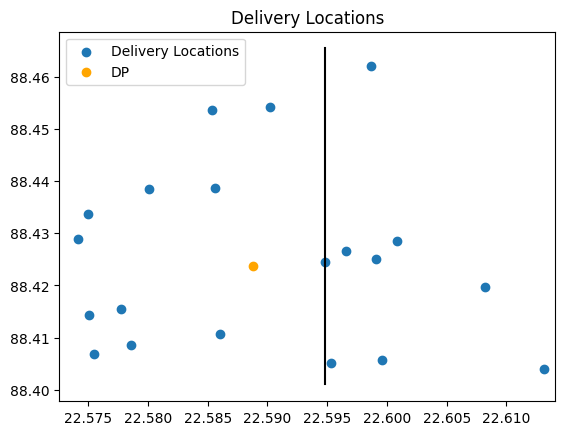

In [85]:
initial_plot(delivery_loc,border,dp=list(final_dp))

In [86]:
route_2 = create_route(delivery_loc,border[0][0],final_dp, euclidean_points, manhattan_points, border_point=border_point if border_point != None else None)

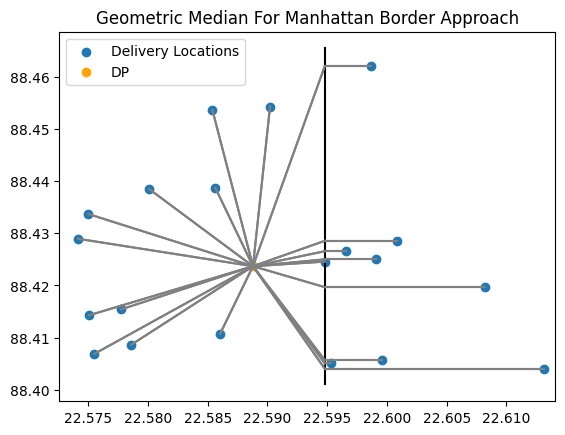

In [87]:
initial_plot(delivery_loc, border, list(final_dp), route_2, title="Geometric Median For Manhattan Border Approach")

In [88]:
# optimal_dp, optimal_route, optimal_distance = optimal_approach(x, y, delivery_loc,border[0][0],euclidean_points,manhattan_points,border_point)

# optimal_dp

In [89]:
# optimal_distance

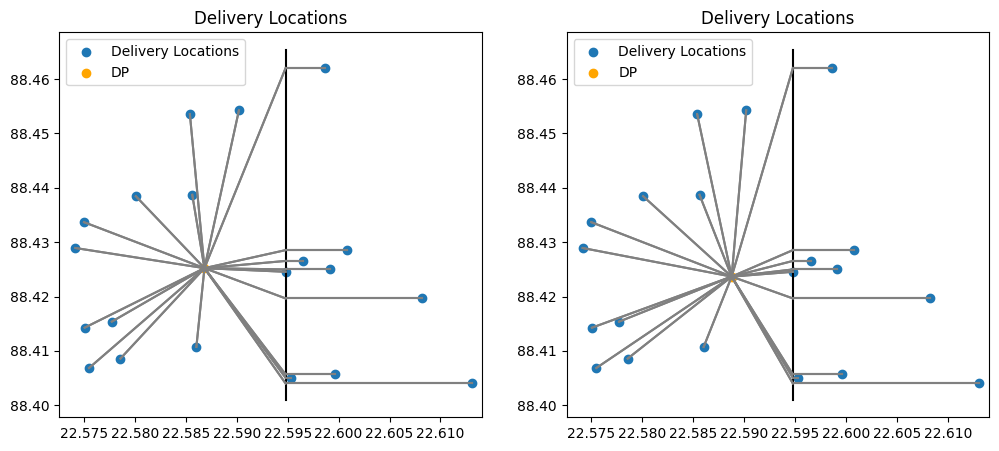

In [90]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
initial_plot(delivery_loc, border, initial_dp, route_1)
plt.subplot(1,2,2)
initial_plot(delivery_loc, border, list(final_dp), route_2)
plt.show()

In [91]:
if total_distance(route_2) < total_distance(route_1):
    Optimal_route = route_2
    distance = total_distance(route_2)
else:
    Optimal_route = route_1
    distance = total_distance(route_1)

In [92]:
print("Final route :", Optimal_route)
print("Final Distance :",distance)

Final route : [array([22.5887904 , 88.42366395]), (22.58603905974058, 88.41071468680073), array([22.5887904 , 88.42366395]), (22.5948, 88.40566489686138), (22.599613780631156, 88.40566489686138), (22.5948, 88.40566489686138), array([22.5887904 , 88.42366395]), (22.5948, 88.42455036624916), (22.594839103178728, 88.42455036624916), (22.5948, 88.42455036624916), array([22.5887904 , 88.42366395]), (22.57500695537815, 88.4336788612174), array([22.5887904 , 88.42366395]), (22.574156069825342, 88.42892678202786), array([22.5887904 , 88.42366395]), (22.57549900007835, 88.40684191805934), array([22.5887904 , 88.42366395]), (22.590217546349415, 88.45424927682888), array([22.5887904 , 88.42366395]), (22.57773778138771, 88.41537658932069), array([22.5887904 , 88.42366395]), (22.5948, 88.46203245589423), (22.598638478729832, 88.46203245589423), (22.5948, 88.46203245589423), array([22.5887904 , 88.42366395]), (22.5948, 88.42654622256751), (22.596549772367627, 88.42654622256751), (22.5948, 88.4265462

In [93]:
# df = pd.read_csv('./delivery_vs_distance_calculation.csv')

# new_row = {
#     'total_delivary':n,
#     'euclidean_points':len(euclidean_points),
#     'manhattan_points':len(manhattan_points),
#     'distance':distance,
# }

# df.loc[len(df)] = new_row

# df.tail()

In [94]:
# try:
#     df.to_csv('./delivery_vs_distance_calculation.csv', index=False)
# except:
#     print("Unknown error occurs")